In [1]:
import torch
import torch.nn as nn

In [2]:
embed_dim = 76

In [27]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=76):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.n_patches = (img_size // patch_size)**2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size= patch_size, stride=patch_size,)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

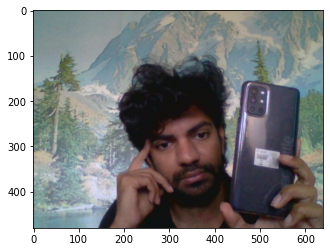

In [28]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms   

img = cv2.imread("img1.jpg")
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize((224, 224))])
img_resize = trans(img)
channels, height, width = img_resize.shape
img_show = img_resize.permute(1,2,0).numpy()
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img_resize.permute(1,2,0).numpy())
plt.imshow(img_show)

In [48]:
patch = PatchEmbed(img_size=height, embed_dim = embed_dim, patch_size = 16)
patches = patch(img_resize.unsqueeze(0))

shape of image 224 and size of patches is 16 and number of patches is 196 that is 14.0*14.0
Feature Maps of the patches created **unflattened for visualization


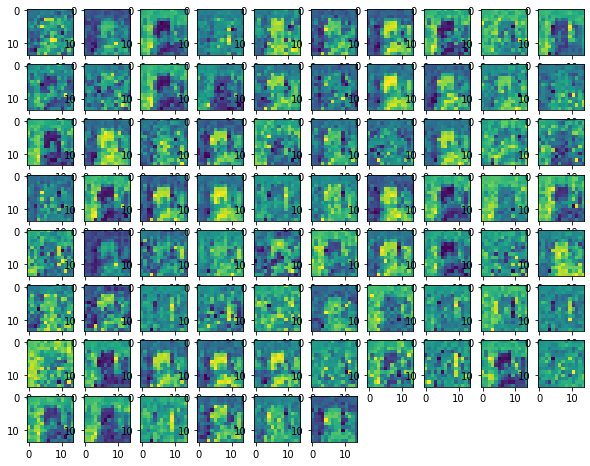

In [49]:
print(f"shape of image {patch.img_size} and size of patches is {patch.patch_size} and number of patches is {patch.n_patches} that is {patch.n_patches**0.5}*{patch.n_patches**0.5}")
print("Feature Maps of the patches created **unflattened for visualization")
plt.figure(figsize=(10,10)) # specifying the overall grid size
the_array = patches.permute(2,1,0).detach().numpy()
for i in range(embed_dim):
    arr = the_array[i].reshape(int(patch.n_patches**0.5), int(patch.n_patches**0.5),1)
    plt.subplot(10,10,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(arr)
plt.show()

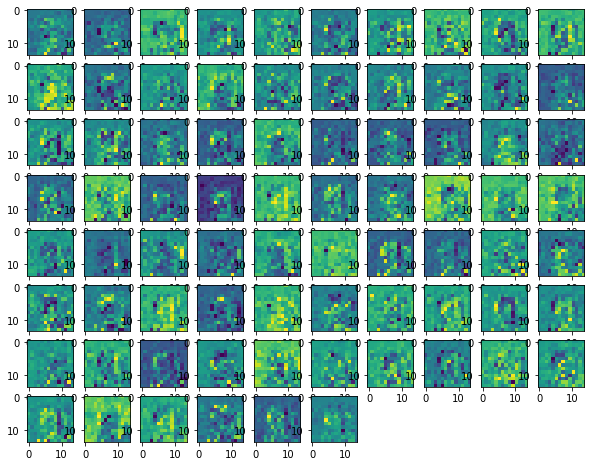

In [50]:
norm = nn.LayerNorm(embed_dim, elementwise_affine=False)
patches = norm(patches)
plt.figure(figsize=(10,10))
the_array = patches.permute(2,1,0).detach().numpy()
for i in range(embed_dim):
    arr = the_array[i].reshape(int(patch.n_patches**0.5), int(patch.n_patches**0.5),1)
    plt.subplot(10,10,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(arr)
plt.show()


#### Add positional embeddings

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=12,qkv_bias = True, attn_p = 0., proj_p=0. ):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim*3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj_drop = nn.Dropout(proj_p)
    
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape # (n_samples, n_patches+1, dim)
        if dim != self.dim:
            raise ValueError
        qkv = self.qkv(x) # (n_samples, n_patches+1, 3*dim)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2,0,3,1,4) # (3,n_samples, n_heads, n_patches+1, head_dim)
        q,k,v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)
        dp = (q @ k_t ) * self.scale # (n_samples, n_heads, n_patches+1, n_patches+1)
        attn = dp.softmax(dim=-1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1,2) # (n_samples, n_patches+1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches+1, dim) same as input
        x = self.proj(weighted_avg)
        x = self.proj_drop(x)
        return x

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio = 4.0, qkv_bias = True, p=0., attn_p=0.):
        super(Block, self).__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(n_heads=n_heads,qkv_bias = qkv_bias, attn_p = attn_p, proj_p=p)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim*mlp_ratio)
        self.mlp = MLP(in_features = dim, hidden_features = hidden_features, out_features=dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size = 384, patch_size = 16, in_chans=3, n_classes=1000, embed_dim=768, 
                                    depth=12, n_heads=12, mlp_ratio=4., qkv_bias=True, p=0.,attn_p=0.):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbed(img_size=img_size,in_chans=in_chans, embed_dim = embed_dim, patch_size = patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,1+self.patch_embed.n_patches,embed_dim))
        self.blocks = nn.ModuleList([Block(
                        dim= embed_dim, n_heads=n_heads, mlp_ratio = mlp_ratio, qkv_bias = qkv_bias, p=p, attn_p=attn_p
        )
        for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples,-1,-1)
        x = torch.cat((cls_token,x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:,0]
        x = self.head(cls_token_final)
        return x